# Updated Instructions (from James)

These are updated instructions using the new API.

## Preparing a SAM segmenter

The first step is to build the SAM segmenter using pretrained weights.

In [ ]:
import attiicc as ac
import matplotlib.pyplot as plt

# Load the SAM model.
weights = '/home/shawarma/ATTIICC/weights/sam_vit_h_4b8939.pth'
sam = ac.SamSegmenter(weights)

## Detect the well plate grid

The next step is to use a reference image to auto-detect the well plate grid. 

This involves segmenting the image using SAM, detecting the wells, and then determining what the well grid layout is like. This grid layout will auto-detect both the shape (contour) and the layout/spacing of the wells.

Removed 13 edge wells.


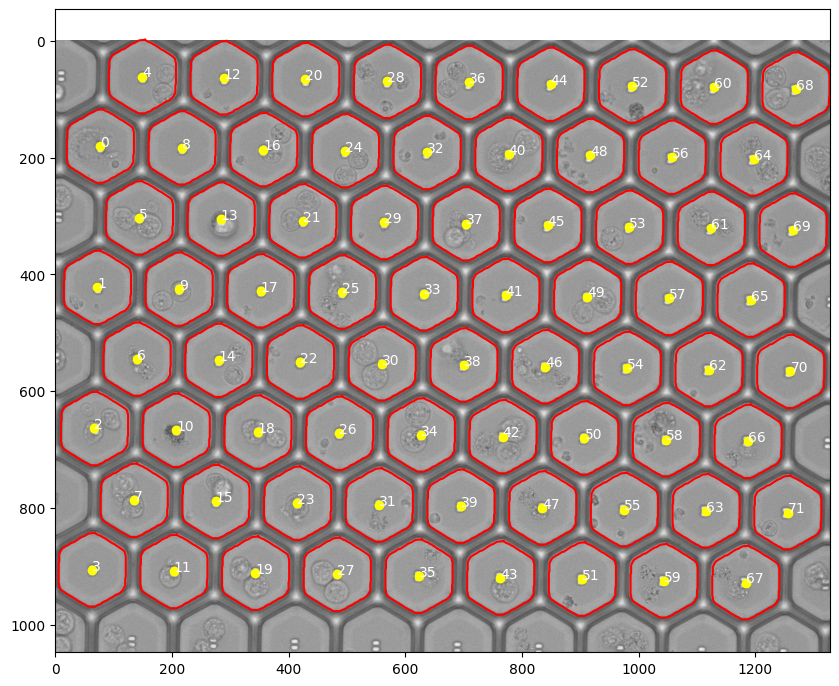

In [2]:
# Use a reference image for learning the well plate grid.
img = '/home/shawarma/ATTIICC/test_data/f00d3/p01_0_A01f00d3.TIF'

# Segment the image.
segmentation = sam.segment(img)

# Find the well plate regions.
# Each region will have its own shape and centroid
# as detected by SAM.
rough_plate = segmentation.find_wells()

# Build the well plate grid.
# This auto-detects the average well plate shape
# and creates a grid of regions
# using this average shape.
plate = rough_plate.build_grid()

# Remove edge wells.
plate.remove_edge_wells()

# Plot the results.
plate.plot()

## Apply the grid to a new image

Once we've defined the grid pattern, we can then apply the pattern to a new image.

The pattern will be automatically aligned and rotated (if necessary) to the new image.

The benefit of applying a predetermined grid pattern is that we'll be getting more consistent and predictable results, without duplicates or outliers.

Removed 12 edge wells.


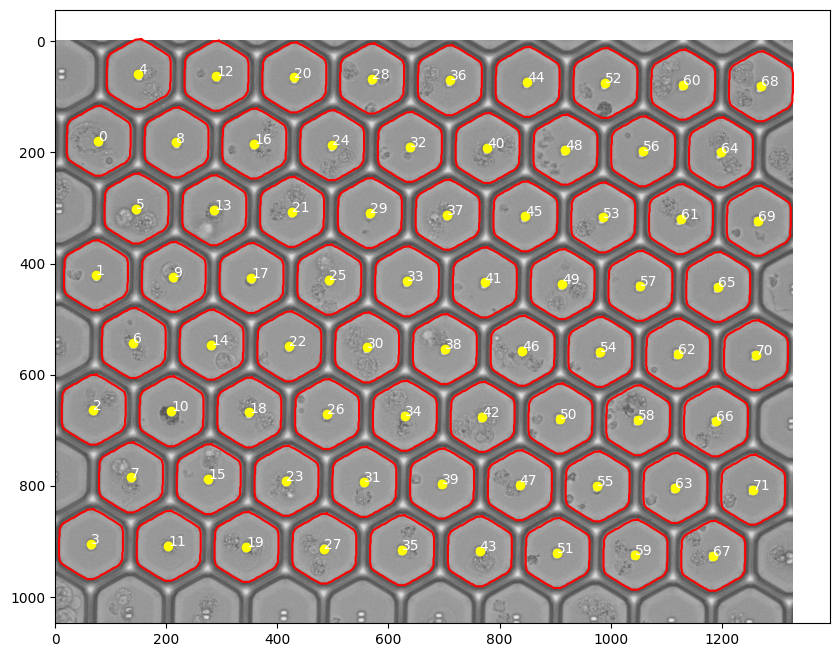

In [4]:
# Load a new image and segment it.
new_img = '/home/shawarma/ATTIICC/test_data/f00d3/p15_0_A01f00d3.TIF'
new_segmentation = sam.segment(new_img)

# Get the grid definition.
grid_definition = plate.grid_definition

# Find the well plate regions.
new_plate = new_segmentation.find_wells()

# Build the well plate grid using the same grid definition.
new_plate = new_plate.apply_grid(grid_definition)

# Remove edge wells.
new_plate.remove_edge_wells()

# Plot the results.
new_plate.plot()

## Stack & align grids across timepoints

For this next phase, we want to be able to stack multiple well plate grids together across time points and align the well regions.

For this, we'll use `PlateStack`, which is assembled from multiple `Plate` objects. We can rapidly build plates from images using `SamSegmenter.build_plates()`.

In [5]:
images = [
    '/home/shawarma/ATTIICC/test_data/f00d3/p01_0_A01f00d3.TIF',
    '/home/shawarma/ATTIICC/test_data/f00d3/p02_0_A01f00d3.TIF',
    '/home/shawarma/ATTIICC/test_data/f00d3/p07_0_A01f00d3.TIF',
    '/home/shawarma/ATTIICC/test_data/f00d3/p15_0_A01f00d3.TIF'
]
# Build well plates for multiple images,
# using the same grid definition.
plates = sam.build_plates(images, grid_definition)

# Let's remove the edge wells from the first plate.
plates[0].remove_edge_wells()

# Next, we'll stack the plates, which will
# ensure that the wells are aligned and in the same order.
stack = ac.PlateStack(*plates)

Removed 13 edge wells.


Just as a sanity check, let's spot-check a couple plates and ensure that everything is aligned and the well labels match.

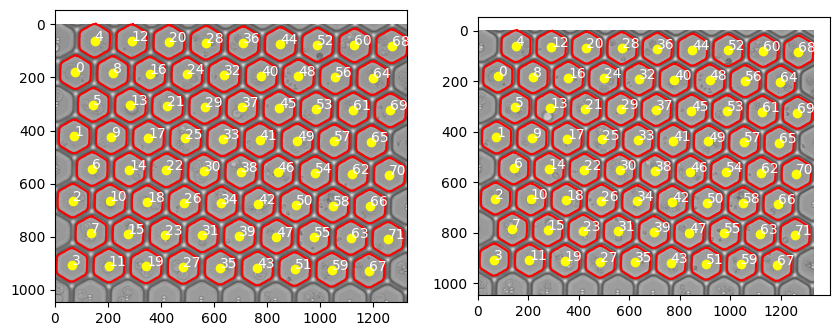

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
stack[0].plot(ax=ax[0])
stack[2].plot(ax=ax[1])

Everything looks aligned! You can now use direct indexing to get corresponding wells across a stack of plates (ie., across time).

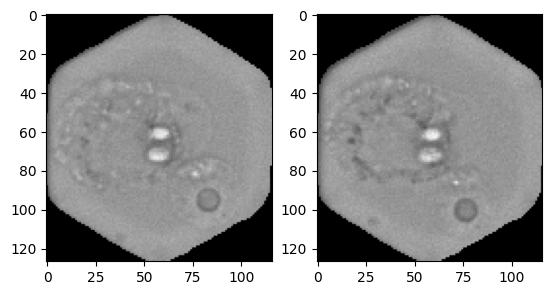

In [7]:
# Get the well plates from the stack.
plate_time1 = stack[0]
plate_time4 = stack[3]

# Get the first well from each plate.
plate_time1_well1 = plate_time1[0]
plate_time4_well1 = plate_time4[0]

# Plot the first well from each plate.
fig, ax = plt.subplots(1, 2)
ax[0].imshow(plate_time1_well1.get_image())
ax[1].imshow(plate_time4_well1.get_image())

You can also use the `Stack.plot_well()` function to show a plot of images for a specific well across time.

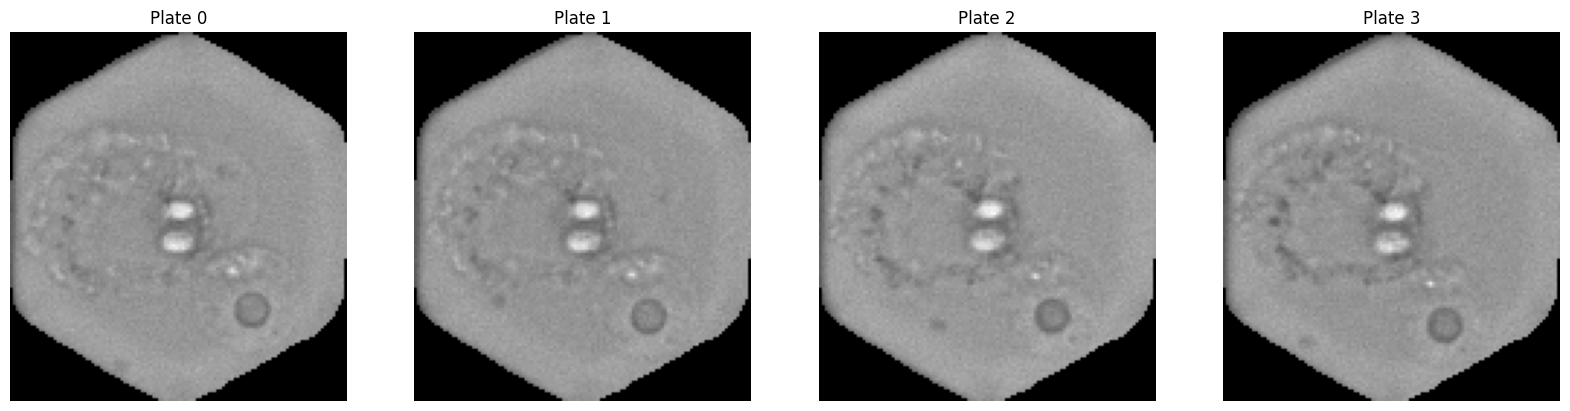

In [8]:
stack.plot_well(0)

# Next steps

Now that we have robust tools for building stacked Plates across time, and pulling matching/longitudinal wells across plates, we have most of what we'd need to carry out the full experiment. 

I have not modified the `NanoExperiment` class or written additional helper functions beyond the functionality above. The above API will need to be adapted for the specific experiment constraints. Hopefully, this API makes stacking and accessing plate well images easier.